# Exploratory data analysis

## 1) The data

<img src="https://raw.githubusercontent.com/wiki/pedropro/TACO/images/logonav.png" alt="[Alt text for the image]" style="width: 30%; height: 30%;">

*Trash Annotations in Context, by Pedro Proença and Pedro Simões*

We will work with data from the [TACO project](http://tacodataset.org/) (Trash Annotations in Context). The images in this project are crowd-sourced, with users manually uploading their images and providing the labels and object masks themselves through an online portal. Submitted images are periodically reviewed, and then added to the official dataset in GitHub. According to its creators, images in the dataset are in contexts ranging *'from tropical beaches to London streets'*. We will describe the dataset in more detail below, but background information on the project can be found on the [TACO website](http://tacodataset.org/) or in the TACO project [GitHub repository](https://github.com/pedropro/TACO). The project creators have also authored an [academic paper](https://arxiv.org/pdf/2003.06975.pdf) with more information on the potential uses of the data.

### Read in data

In [1]:
# Suppressing warnings to maintain clean output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import packages
import sys
import os
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

In [3]:
# Import our helper functions to resize images
from cv_helper_functions import *

In [4]:
# Retrieve directory where we will get the raw data from
parent_directory = os.path.abspath('../')
dataset_path = "/kaggle/input/tacotrashdataset/data"

# Retrieve directory where we will get save processed data and features
features_path = os.path.join(parent_directory,'data/features')
os.makedirs(features_path, exist_ok=True)

We load in an extract of the TACO data which is composed of:
* 1,500 raw images, stored in 15 sub-folders labelled "batch 1" to "batch 15".
* A json file called "annotations.json", organised in the convenient [COCO-Json](https://haobin-tan.netlify.app/ai/computer-vision/object-detection/coco-dataset-format/) format, widely used for object detection datasets.

In [5]:
# Read annotations file
with open("{}/annotations.json".format(dataset_path), 'r') as f:
    annotdata = json.loads(f.read())

### Show sample of images

Next, we will visualize a random sample of the images and annotations. To visualize this, we have adapted a function provided by [Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/blob/master/335%20-%20Converting%20COCO%20JSON%20annotations%20to%20labeled%20mask%20images/335c-visualize-COCO%20labels.pyhttps://github.com/bnsreenu/python_for_microscopists/blob/master/335%20-%20Converting%20COCO%20JSON%20annotations%20to%20labeled%20mask%20images/335c-visualize-COCO%20labels.py) to display images annotated in the COCO-Json format.

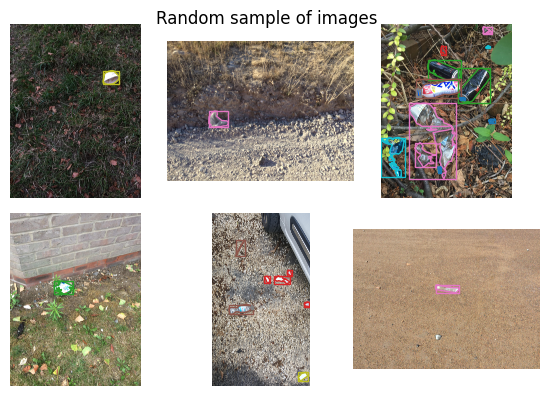

In [6]:
import matplotlib.patches as patches

# Randomly select 6 image IDs from the dataset
random_images = pd.Series([line["id"] for line in annotdata["images"]]).sample(6, random_state=1)

# Display images along with COCO annotations
display_images_with_coco_annotations(
    image_id_subset=random_images,  # Subset of image IDs
    figtitle="Random sample of images",  # Title for the figure
    dataset_path=dataset_path,  # Path to the dataset
    annotations=annotdata,  # COCO annotations
    display_type='both'  # Display type for annotations
)

From our snapshot of the data above, we can see that the images will need some processing before we can apply our machine learning models:

* Often, the object is very small in relation to the image background. This is particularly the case for small objects, like cigarette butts.
* Some objects appear 'distorted' - for example, they are bent or broken. This appears to be more common among objects photographed outdoors and those made of soft materials (like plastic film or cardboard). These distortions might make the images more difficult to classify.
* Object masks (the segmentations, such as the contour of a plastic bottle) are not provided as stand-alone images, so we will need to create them for each annotation.

## 2) Exploratory data analysis

### Missing data and duplicates

#### Image dataset

First, we conduct some exploratory data analysis at the image level. We start by saving the images data into a pandas DataFrame.First, we conduct some exploratory data analysis at the image level. We start by saving the images data into a pandas DataFrame. The images file contains one row per image in the dataset, for a total of 1,500 images. It contains:

* An image id
* Image width
* Image height
* File name (and its batch)
* Type of license

All information on the date captured is missing, and there are no duplicates in the images dataset.

In [7]:
# Preview image data
pd.DataFrame(annotdata["images"]).head()

id  width  height           file_name license  \
0   0   1537    2049  batch_1/000006.jpg    None   
1   1   1537    2049  batch_1/000008.jpg    None   
2   2   1537    2049  batch_1/000010.jpg    None   
3   3   2049    1537  batch_1/000019.jpg    None   
4   4   1537    2049  batch_1/000026.jpg    None   

                                          flickr_url coco_url date_captured  \
0  https://farm66.staticflickr.com/65535/33978196...     None          None   
1  https://farm66.staticflickr.com/65535/47803331...     None          None   
2  https://farm66.staticflickr.com/65535/40888872...     None          None   
3  https://farm66.staticflickr.com/65535/47803331...     None          None   
4  https://farm66.staticflickr.com/65535/33978199...     None          None   

                                      flickr_640_url  
0  https://farm66.staticflickr.com/65535/33978196...  
1  https://farm66.staticflickr.com/65535/47803331...  
2  https://farm66.staticflickr.com/65535/40888872...  
3  https://farm66.staticflickr.com/65535/47803331...  
4  https://farm66.staticflickr.com/65535/33978199...

<Axes: >

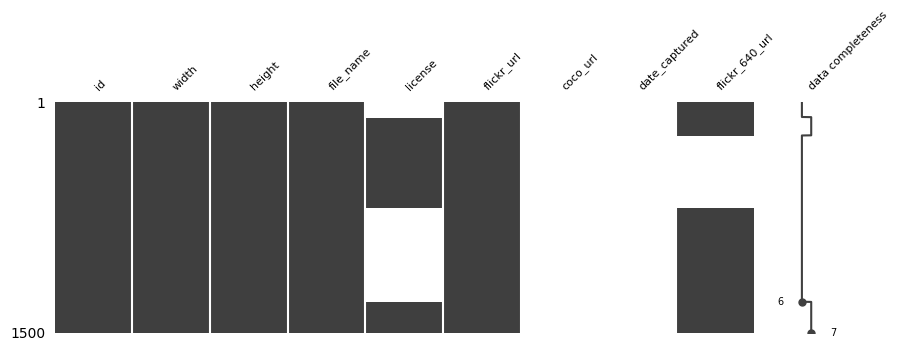

In [8]:
# Check missing data
import missingno as msno
msno.matrix(pd.DataFrame(annotdata["images"]), fontsize=8,labels=True, figsize=(10,3))

#### Annotations dataset

The annotations file is where we will find most of the relevant information for our analysis. This is where each annotation (e.g. the contour of a plastic bottle and the 'plastic bottle' tag) is stored. There are 4,784 annotations in this version of the dataset.

This dataset includes:

* The annotation id (id)
* Its corresponding image id (image_id)
* The category id (category_id), i.e. whether the annotation is a bottle, a pizza box or other.
* The segmentation itself ('segmentation'), with values indicating which pixels are within the segment (also called the 'mask').
* The annotation area ('area').
* The bounding box for the annotation ('bbox'), i.e. the rectangular area containing the edges of the annotation. This is a list of four numbers representing the bounding box of the annotated object in the format [x, y, width, height], where (x, y) is the top-left corner of the bounding box ([more information here on bounding boxes in COCO](https://medium.com/@manuktiwary/coco-format-what-and-how-5c7d22cf5301)).

In [9]:
# Preview data
pd.DataFrame(annotdata["annotations"]).head()

id  image_id  category_id  \
0   1         0            6   
1   2         1           18   
2   3         1           14   
3   4         2            5   
4   5         2            7   

                                        segmentation       area  \
0  [[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...   403954.0   
1  [[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...  1071259.5   
2  [[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...    99583.5   
3  [[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...    73832.5   
4  [[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...      915.0   

                            bbox  iscrowd  
0  [517.0, 127.0, 447.0, 1322.0]        0  
1   [1.0, 457.0, 1429.0, 1519.0]        0  
2  [531.0, 292.0, 1006.0, 672.0]        0  
3   [632.0, 987.0, 500.0, 374.0]        0  
4     [632.0, 989.0, 44.0, 51.0]        0

In [10]:
# Save to DataFrame
annot_df = pd.DataFrame(annotdata["annotations"]).drop(["area"], axis=1)

We drop the duplicated annotation (which is tagged with two different categories).

In [11]:
# Drop duplicates
annot_df.drop_duplicates(subset=['id'], keep='first', inplace=True)

Then, we merge in the annotation category labels so that we can conveniently see to which category and supercategory each annotation belongs.

In [12]:
# Merge annotations to image data
categories_dict = pd.DataFrame(annotdata["categories"]).loc[:,["id","name","supercategory"]]
categories_dict.rename({'id': 'category_id', 'name': 'category'}, axis=1, inplace=True)
annot_df = annot_df.merge(categories_dict, on='category_id', how='left').copy()
annot_df.head()

id  image_id  category_id  \
0   1         0            6   
1   2         1           18   
2   3         1           14   
3   4         2            5   
4   5         2            7   

                                        segmentation  \
0  [[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...   
1  [[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...   
2  [[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...   
3  [[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...   
4  [[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...   

                            bbox  iscrowd              category supercategory  
0  [517.0, 127.0, 447.0, 1322.0]        0          Glass bottle        Bottle  
1   [1.0, 457.0, 1429.0, 1519.0]        0           Meal carton        Carton  
2  [531.0, 292.0, 1006.0, 672.0]        0          Other carton        Carton  
3   [632.0, 987.0, 500.0, 374.0]        0  Clear plastic bottle        Bottle  
4     [632.0, 989.0, 44.0, 51.0]        0    Plastic bottle cap    Bottle cap

We would like to visualize the most common supercategories. The most common supercategory is **plastic bag and wrapper**, which contains many different types of objects such as plastic film, carrier bags and crisp packets. The second most common supercategory are **cigarettes**, followed by **unlabelled litter**. Some supercategories, like shoes or batteries, are very rare.

In [13]:
# Counts by image category
counts_by_cat = pd.DataFrame(annot_df.groupby(["supercategory","category"]).size(),columns=["count"]).reset_index()
counts_by_cat["supercount"] = counts_by_cat.groupby("supercategory")["count"].transform('sum')
counts_by_cat = counts_by_cat.sort_values(by=['supercount','count'], ascending=False)

# Associate a color with each supercategory
unique_supercategories = counts_by_cat['supercategory'].unique()
supercategory_colors = dict(zip(unique_supercategories, sns.color_palette("tab10", len(unique_supercategories))))
counts_by_cat['color'] = counts_by_cat['supercategory'].map(supercategory_colors)

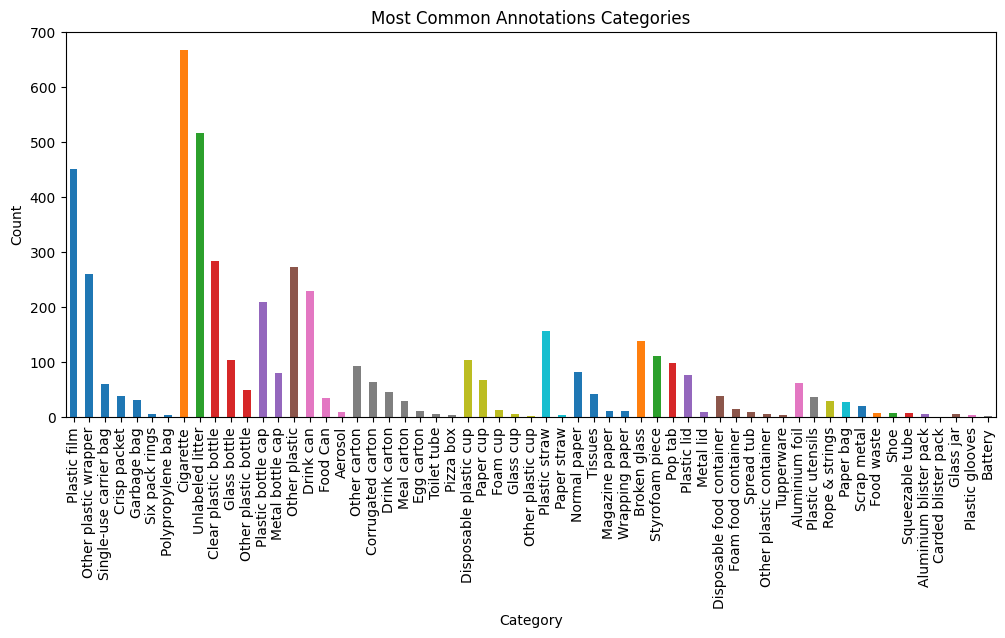

In [14]:
# Create the bar chart with colormap
plt.figure(figsize=(12, 5))
counts_by_cat.set_index("category")["count"].plot(kind="bar", color=counts_by_cat.color)

# Remove legend (optional)
plt.legend().remove()

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Most Common Annotations Categories")

plt.show()

### Create class labels for classification problems

Our classification task will try to distinguish between five types of objects:
* Bottles
* Cartons
* Cups
* Cans
* Plastic film

We create the string variable 'c1_label' containing the object labels according to the above taxonomy, and its numerical version 'c1_numlabel'.

In [15]:
# Create the c1 "label" variable
annot_df["c1_label"] = np.nan
annot_df.loc[annot_df["supercategory"]=="Bottle","c1_label"] = "Bottle"
annot_df.loc[annot_df["supercategory"]=="Carton","c1_label"] = "Carton"
annot_df.loc[annot_df["supercategory"]=="Cup","c1_label"] = "Cup"
annot_df.loc[annot_df["category"].isin(["Drink can","Food can"]),"c1_label"] = "Can"
annot_df.loc[annot_df["category"].isin(["Plastic film"]),"c1_label"] = "Plastic film"

# Create the numerical "label" variable
annot_df["c1_numlabel"] = annot_df['c1_label'].replace(list(annot_df['c1_label'].value_counts().index),list(range(1,6)), inplace=False)

## 3) Save data

Having merged the information on images properties (e.g. size and bounding box coverage), background annotations and class labels to our annotations dataframe, we can save this DataFrame to a '.csv' file locally.

In [16]:
# Preview data
annot_df.head()

id  image_id  category_id  \
0   1         0            6   
1   2         1           18   
2   3         1           14   
3   4         2            5   
4   5         2            7   

                                        segmentation  \
0  [[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...   
1  [[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...   
2  [[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...   
3  [[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...   
4  [[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...   

                            bbox  iscrowd              category supercategory  \
0  [517.0, 127.0, 447.0, 1322.0]        0          Glass bottle        Bottle   
1   [1.0, 457.0, 1429.0, 1519.0]        0           Meal carton        Carton   
2  [531.0, 292.0, 1006.0, 672.0]        0          Other carton        Carton   
3   [632.0, 987.0, 500.0, 374.0]        0  Clear plastic bottle        Bottle   
4     [632.0, 989.0, 44.0, 51.0]        0    Plastic bottle cap    Bottle cap   

  c1_label  c1_numlabel  
0   Bottle          2.0  
1   Carton          3.0  
2   Carton          3.0  
3   Bottle          2.0  
4      NaN          NaN

In [17]:
# Save data
annot_df.to_csv("{}/{}".format(features_path,"clean-annotations-data.csv"))

# Selecting samples and preprocessing images for machine learning models

## 1) Load clean data

In this second notebook, we start by importing the original annotations dataset (*annotdata*) and the 'clean' version we produced that includes additional variables used in exploratory data analysis (*annot_df*).

In [18]:
# Read clean annotations file
annot_df = pd.read_csv("{}/{}".format(features_path,"clean-annotations-data.csv"))

## 2) Functions to process images for machine learning models

We have written three functions that will process our images in preparation for our machine learning models.:

- **Show annotation**: The first function simply takes an _annotation id_ and returns the image containing this annotation, without any additional transformations.
- **Crop image around annotation**: The purpose of the second function is to crop the image around the annotation (with id _annotation_id_), thus removing background elements (such as a road or a landscape). It should be easier to classify images if objects are in the centre of the image and we and remove other objects around it.
- **Create annotation mask**: The third function creates a "black and white" image showing the contour of each annotation.

### Crop image around annotation

The first step is to load the image containing the annotation of interest. Then, we recover the annotation bounding box from the annotations COCO-Json file and compute the bounding box centroid.

Next, we draw a square around this centroid and control the size of the square side with the parameter **widen_param**:

- If **widen_param** is 0, its smallest allowed value, then we will draw the smallest square possible around the annotation bounding box while retaining the entire bounding box.
- If **widen_param** is 1, its allowed largest value, then the side of the square will be equal to the side of the original image (either the width or the height, whichever is highest). Occasionally, the boundaries of this square fall outside the image itself. For example, if the object was near a corner. In that case, the cropped area is no longer square and will be rectangular. If this is the case, we add black borders around the rectangle to make it square.

The side of the final square can be controlled with the **newsize** parameter.

We demonstrate how this function works by showing an example with three values of the **widen_param** parameter.

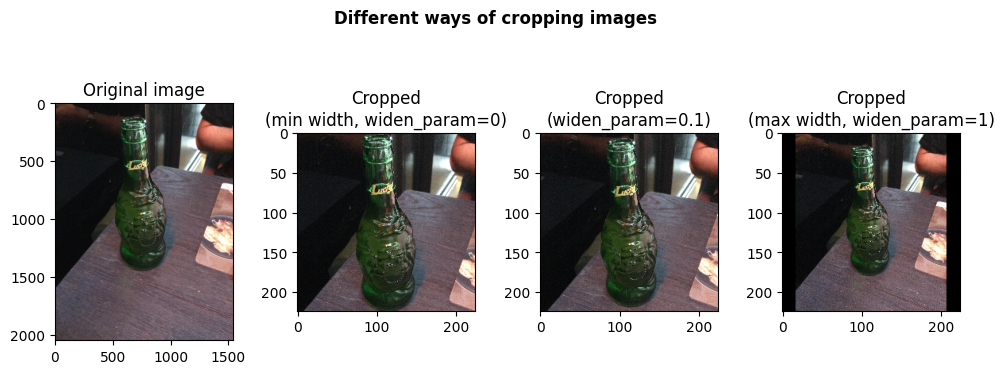

In [19]:
# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

# Flatten the axes array
axes = axes.flatten()

# Display original image
axes[0].imshow(show_annotation_image(annotation_id=1, annotations=annotdata, dataset_path=dataset_path))
axes[0].set_title("Original image")

# Display cropped image with minimum width
axes[1].imshow(try_square_crop(annotation_id=1, annotations=annotdata, widen_param=0, newsize=224, dataset_path=dataset_path))
axes[1].set_title("Cropped\n(min width, widen_param=0)")

# Display cropped image with slight widening
axes[2].imshow(try_square_crop(annotation_id=1, annotations=annotdata, widen_param=0.1, newsize=224, dataset_path=dataset_path))
axes[2].set_title("Cropped\n(widen_param=0.1)")

# Display cropped image with maximum width
axes[3].imshow(try_square_crop(annotation_id=1, annotations=annotdata, widen_param=1, newsize=224, dataset_path=dataset_path))
axes[3].set_title("Cropped\n(max width, widen_param=1)")

# Add title to the figure
fig.suptitle("Different ways of cropping images", fontsize=12, fontweight="bold")

# Adjust layout to fit the title properly
plt.tight_layout(rect=[0, 0, 0.98, 0.98])

# Show the plot
plt.show()

### Create image mask

The function below has two steps:

* It converts the annotation into a new image (_a mask_) showing the contours of the annotation. This was adapted from a function written by [Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/blob/master/335%20-%20Converting%20COCO%20JSON%20annotations%20to%20labeled%20mask%20images/335d-convert_coco_to_labeled_masks.py).
* Then, it crops the resulting mask image in exactly the same way as the function described above (try_square_crop).

By using these two functions, each processed image will have its equivalent mask image that exactly mirrors the original image in terms of where the object is located.

We demsonstrate how this function works below, using the same source image.

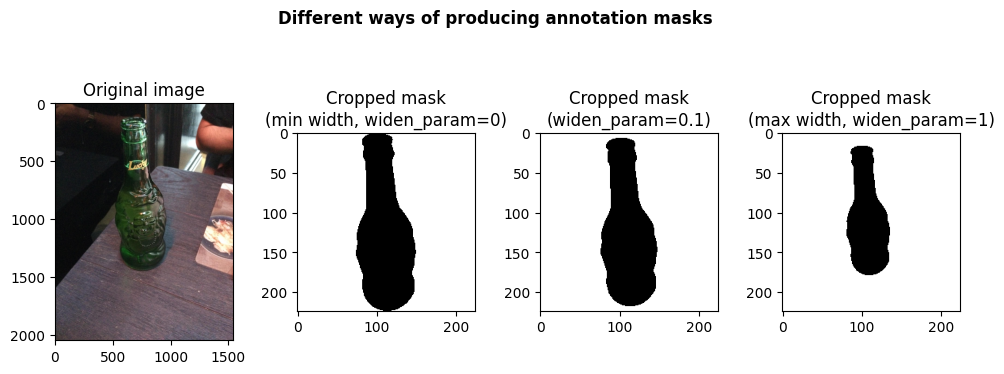

In [20]:
# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

# Flatten the axes array
axes = axes.flatten()

# Display original image with grayscale colormap
axes[0].imshow(show_annotation_image(annotation_id=1, annotations=annotdata, dataset_path=dataset_path), cmap="Greys")
axes[0].set_title("Original image")

# Display cropped mask image with minimum width
axes[1].imshow(mask_and_square_crop(annotation_id=1, annotations=annotdata, widen_param=0, newsize=224, dataset_path=dataset_path), cmap="Greys")
axes[1].set_title("Cropped mask\n(min width, widen_param=0)")

# Display cropped mask image with slight widening
axes[2].imshow(mask_and_square_crop(annotation_id=1, annotations=annotdata, widen_param=0.1, newsize=224, dataset_path=dataset_path), cmap="Greys")
axes[2].set_title("Cropped mask\n(widen_param=0.1)")

# Display cropped mask image with maximum width
axes[3].imshow(mask_and_square_crop(annotation_id=1, annotations=annotdata, widen_param=1, newsize=224, dataset_path=dataset_path), cmap="Greys")
axes[3].set_title("Cropped mask\n(max width, widen_param=1)")

# Add title to the figure
fig.suptitle("Different ways of producing annotation masks", fontsize=12, fontweight="bold")

# Adjust layout to fit the title properly
plt.tight_layout(rect=[0, 0, 0.98, 0.98])

# Show the plot
plt.show()

## 3) Selecting samples for machine learning models

### Selecting samples for classification model

Based on our exploratory analysis, we restrict our classification task to the following objects:

* Bottles
* Cartons
* Cups
* Cans
* Plastic film

This results in 1,561 total usable annotations. The variables useful for classification, including the labels and image and annotation id's are stored in DataFrame 'annot_df_c1'.

In [21]:
# Select a subset of the data
annot_df_c1 = annot_df.dropna(subset=['c1_label'], inplace=False)
annot_df_c1.reset_index(drop=True, inplace=True)
annot_df_c1.shape

(1561, 11)

In [22]:
# Only keep the relevant columns
annot_df_c1 = annot_df_c1[["id","image_id","category_id","c1_numlabel","c1_label"]].copy()

Some of our 1,561 annotations are in fact in the same image. For example, 340 images contain two different annotations. However, if we use our image cropping approach around each annotation bounding box, we can treat each of these as separate images.

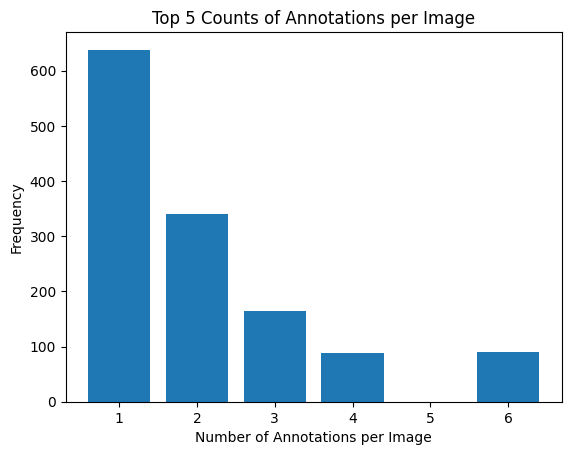

In [23]:
# Compute annotations by image
annot_df_c1["annotations_by_image"] = annot_df_c1.groupby('image_id')['id'].transform('count')

# Get the top 5 value counts
top_counts = annot_df_c1["annotations_by_image"].value_counts()[:5]

# Plotting the bar graph
plt.bar(top_counts.index, top_counts.values)
plt.xlabel('Number of Annotations per Image')
plt.ylabel('Frequency')
plt.title('Top 5 Counts of Annotations per Image')
plt.show()

For this classification problem, we choose a widen_param of 0.05 - this results in a close crop around the annotation bounding box but retains a small amount of backround elements as shown below.

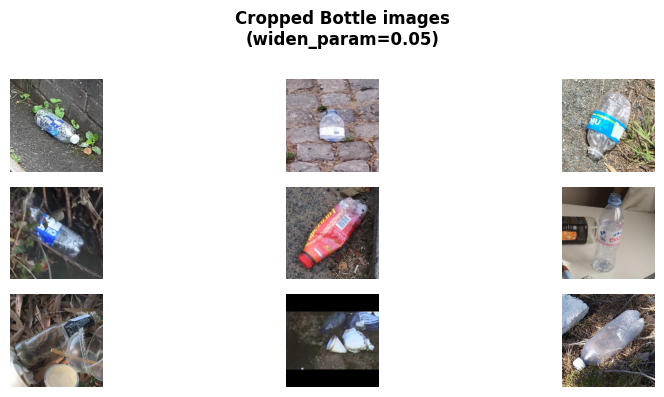

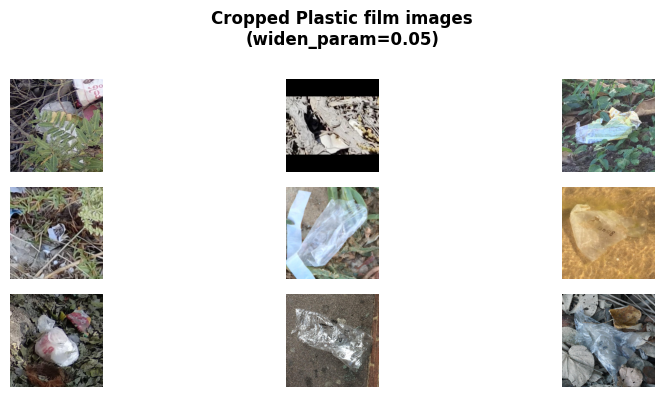

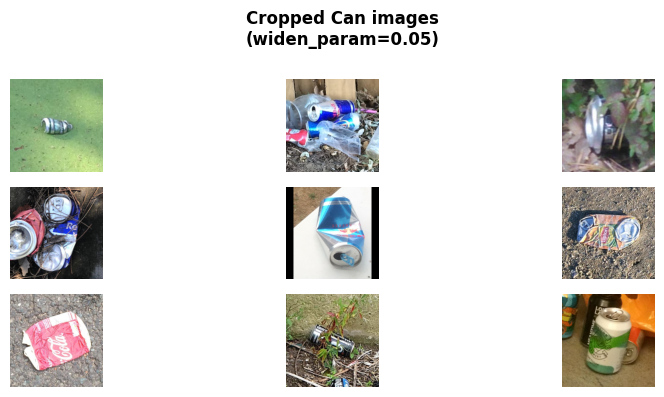

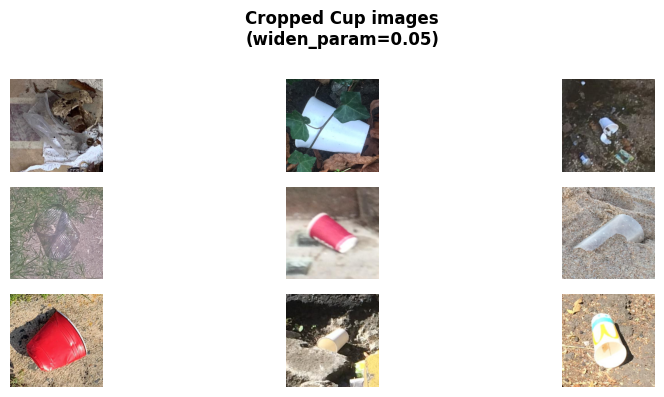

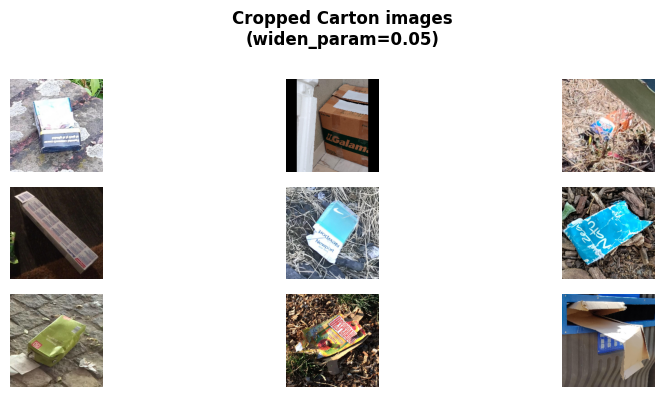

In [24]:
def plot_cropped_images(label, annotations_df, annotdata, widen_param=0.05, newsize=224, dataset_path=None):
    # Select samples for the given label
    annotations_samples = sample(list(annotations_df.loc[annotations_df.c1_label == label, "id"]), 9)
    
    # Create subplots
    fig, axes = plt.subplots(3, 3, figsize=(10, 4))
    
    # Plot cropped images
    for (annotindex, ax) in zip(annotations_samples, axes.flatten()):
        ax.imshow(try_square_crop(annotindex, annotations=annotdata, widen_param=widen_param, newsize=newsize, dataset_path=dataset_path))
        ax.set_axis_off()
    
    # Set title and adjust layout
    fig.suptitle(f"Cropped {label} images\n(widen_param={widen_param})", fontsize=12, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 0.98, 0.98])
    plt.show()

# Plot cropped images for each category
categories = ["Bottle", "Plastic film", "Can", "Cup", "Carton"]
for category in categories:
    plot_cropped_images(category, annot_df_c1, annotdata, widen_param=0.05, newsize=224, dataset_path=dataset_path)


### Selecting samples for image segmentation analysis

For our image segmentation task, we will focus on images of bottles. However, we will only work with images that have a single bottle. This leaves us with 248 images.

In [25]:
# Filter annotations DataFrame to include only annotations related to the "Bottle" supercategory
annot_df_s1 = annot_df.loc[annot_df["supercategory"].isin(["Bottle"]), :]

# Extract relevant columns and create a copy
annot_df_s1 = annot_df_s1[["id", "image_id", "category_id"]].copy()

# Count the number of annotations per image and create a new column
annot_df_s1["annotations_by_image"] = annot_df_s1.groupby('image_id')['id'].transform('count')

# Keep only images with one annotation
annot_df_s1 = annot_df_s1.loc[annot_df_s1.annotations_by_image == 1, :].copy()

# Reset index and update DataFrame shape
annot_df_s1.reset_index(drop=True, inplace=True)
annot_df_s1.shape

(248, 4)

### Saving classification labels

In [26]:
# Save classification labels
np.savez("{}/{}".format(features_path,"classification-labels.npz"), c1=annot_df_c1, s1=annot_df_s1,
         c1_colnames=annot_df_c1.columns, s1_colnames=annot_df_s1.columns)

## 4) Process images for machine learning models

Finally, we process the images we will use in our classification and segmentation tasks. As a reminder:

* For our classification tasks, this means resizing and cropping the images in a square around the annotation bounding box and, if necessary, adding a black border.
* On top of the above, for our segmentation task, we also need to produce image masks that mirror exactly the same transformations applied to the original images.

We do this for three values of the *widen_param* parameter, so we can perform sensitivity analyses in our machine learning tasks if needed.

In [27]:
# Change the value of generate_cropped_images to True if you wish to generate the cropped images
# This only needs to be done once, as it can be time consuming
generate_cropped_images = True

In [28]:
# Only run if generate_cropped_images is True
if generate_cropped_images:
    for width in [0.05]:
        # Generate images for task C1, and store as a 4-dimensional numpy array
        c1_data = [try_square_crop(idx, annotations=annotdata, widen_param=width, newsize=224, dataset_path=dataset_path) for idx in list(annot_df_c1.id)]
        c1_data = np.stack(c1_data, axis=0)

        # Find the locations (indices) of images for task S1 within the set prepared for task C1 (S1 is also a subset of C1)
        # And store those images is a separate 4-dimensional numpy array
        s1_locations_in_c1 = annot_df_s1["id"].map(lambda x: annot_df_c1.index[annot_df_c1.id==x][0])
        s1_data = c1_data[s1_locations_in_c1,:,:,:]

        # Create binary image masks for images used in task S1
        # And store those images in a separate 4-dimensional numpy array
        s1_masks = [mask_and_square_crop(idx, annotations=annotdata, widen_param=width, newsize=224, dataset_path=dataset_path) for idx in list(annot_df_s1.id)]
        s1_masks = np.stack(s1_masks, axis=0)

        # Create folder to store the transformed images and masks
        destination = "{}/{}".format(features_path,"widen_param_{}".format(width))
        os.makedirs(destination, exist_ok=True)

        # Save data
        np.savez("{}/{}".format(destination,"classification-images.npz"), c1=c1_data, s1=s1_data, s1_masks=s1_masks)

# Classifying objects

In this notebook, we will use machine learning models to classify images of:
    
* Bottles
* Cartons
* Cups
* Cans
* Plastic film

## 1) Load packages

## 2) Load data for classification models

In the previous steps, we selected 1,561 samples (or annotations) to use in our first classification problem. The class labels for those samples are included in the dataset 'c1_info', which we load again below.

In [29]:
# Load the image labels and information
with np.load("{}/{}".format(features_path,"classification-labels.npz"), allow_pickle=True) as npz_file:
    # It's a dictionary-like object
    print(list(npz_file.keys()))

    # Load the arrays
    c1_info = npz_file["c1"]
    c1_info_colnames = npz_file["c1_colnames"]

c1_info = pd.DataFrame(c1_info, columns=c1_info_colnames)
c1_info

['c1', 's1', 'c1_colnames', 's1_colnames']


id image_id category_id c1_numlabel c1_label annotations_by_image
0        1        0           6         2.0   Bottle                    1
1        2        1          18         3.0   Carton                    2
2        3        1          14         3.0   Carton                    2
3        4        2           5         2.0   Bottle                    1
4        6        3           5         2.0   Bottle                    3
...    ...      ...         ...         ...      ...                  ...
1556  4776     1497           6         2.0   Bottle                    2
1557  4777     1497           6         2.0   Bottle                    2
1558  4779     1498          16         3.0   Carton                    1
1559  4782     1499          14         3.0   Carton                    2
1560  4783     1499           6         2.0   Bottle                    2

[1561 rows x 6 columns]

We also load the preprocessed images themselves, which are stored in a 4-dimensional numpy array 'c1_images'.

In [30]:
# Load the processed (cropped+framed) images
with np.load("{}/{}/{}".format(features_path,"widen_param_0.05","classification-images.npz"), allow_pickle=True) as npz_file:
    # Print the keys
    print(list(npz_file.keys()))

    # Load the arrays
    c1_images = npz_file["c1"]

['c1', 's1', 's1_masks']


We can see from the pie chart below that our original sample was unbalanced: the most frequent cateogory, plastic film (29%), has more than twice the number of samples as the least common category, cups (12%).

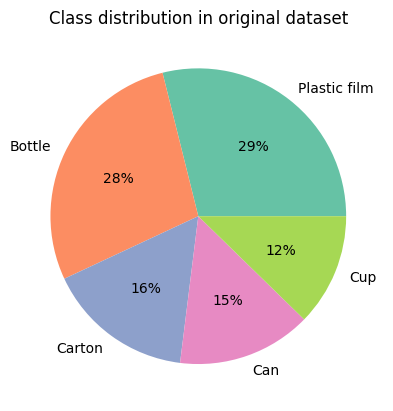

In [31]:
# Pie chart
piecolors = sns.color_palette('Set2',5)
plt.pie(c1_info.c1_label.value_counts(normalize=False), labels = c1_info.c1_label.value_counts(normalize=False).index, colors = piecolors, autopct='%.0f%%')
plt.title("Class distribution in original dataset")
plt.show()

## 3) Extract features

We use a pre-trained model, ResNet50V2, to create features that we will use in our machine learning models. ResNet50V2 is a deep convolutional neural network architecture used for image classification. This model was trained on the ImageNet dataset, which contains over 1 million images from [1,000 different image categories](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/). It has a top-1 accuracy of 76.0% on those classes.

This dataset includes a wide variety of images, such as animals, objects and people. Looking at the 1,000 categories included in ImageNet we can see that ResNet50V2 has already been trained to detect some of our classes, such as cans and bottles. Therefore, we expect it to perform well on our selected sample of images.

In [32]:
# Import tensorflow
import tensorflow as tf
import tensorflow_hub as hub

2024-05-15 20:23:19.359214: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 20:23:19.359328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 20:23:19.481969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


First, we check that our images have the required shape of 224x224 pixels, and we rescale the values for each pixel to the 0-1 range.

In [33]:
# Rescale array of images
c1_data_processed = c1_images*1./255.

In [34]:
# Feature extractor
feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224, 224, 3)) # define the input image shape

Then, we generate our 2,048 features in batches of 10 images to avoid overwhelming our runtime's memory.

In [35]:
# Initialize an empty DataFrame to store features
c1_features = pd.DataFrame()

# Generate high-level features in batches
batch_size = 10
num_samples = c1_data_processed.shape[0]

for i in range(0, num_samples, batch_size):
    batch_data = c1_data_processed[i:i+batch_size]
    batch_features = feature_extractor_layer(batch_data).numpy()
    batch_features_df = pd.DataFrame(batch_features)
    
    if c1_features.empty:
        c1_features = batch_features_df
    else:
        c1_features = pd.concat([c1_features, batch_features_df])

# Reset index
c1_features.reset_index(drop=True, inplace=True)

Then, we add our class labels (in string and numeric format) back into the features dataset.

In [36]:
# Create training dataframe with features from ResNet50V2
c1_features.reset_index(drop=True,inplace=True)
c1_features.columns = c1_features.columns+1
c1_features = c1_features.add_prefix('feat_')

# Add variables
c1_features["annotation_id"] = c1_info["id"].copy()
c1_features["c1_label"] = c1_info["c1_label"].copy()
c1_features["c1_numlabel"] = c1_info["c1_numlabel"].copy()
c1_features = c1_features[c1_features.columns[::-1]]

#I nspect first few rows
c1_features.head(10)

c1_numlabel c1_label annotation_id  feat_2048  feat_2047  feat_2046  \
0         2.0   Bottle             1   0.000000   0.044905   0.458289   
1         3.0   Carton             2   0.000000   0.386239   0.098850   
2         3.0   Carton             3   0.187231   0.732538   0.006494   
3         2.0   Bottle             4   0.036741   0.000000   0.000000   
4         2.0   Bottle             6   0.000000   0.019879   0.087684   
5         2.0   Bottle             7   2.873828   0.280253   0.000000   
6         4.0      Can             9   0.061461   0.180357   0.233666   
7         4.0      Can            10   0.265030   0.064462   2.187935   
8         2.0   Bottle            13   0.125772   0.242572   0.291256   
9         2.0   Bottle            18   0.631636   0.821873   0.603611   

   feat_2045  feat_2044  feat_2043  feat_2042  ...   feat_10    feat_9  \
0   0.009589   0.047127   0.137337   0.000138  ...  2.707892  5.242393   
1   0.000000   0.027284   0.000000   0.000000  ...  0.040368  1.093138   
2   0.000000   0.000000   0.074635   0.000000  ...  0.009037  0.670305   
3   0.000000   0.251849   0.000000   0.000000  ...  0.000000  0.374465   
4   0.000000   0.289862   0.820695   0.000000  ...  0.720959  0.710165   
5   0.186077   0.212173   0.349028   0.000000  ...  0.000000  0.000000   
6   0.000000   0.062664   0.000000   0.003532  ...  0.654771  1.557487   
7   0.000000   0.000000   0.824286   0.003866  ...  0.546349  1.426703   
8   0.000000   0.000000   0.000000   0.000000  ...  0.239354  1.146632   
9   0.000000   0.255274   0.000000   0.000213  ...  0.000000  0.306255   

     feat_8    feat_7    feat_6    feat_5    feat_4    feat_3    feat_2  \
0  0.000000  1.197523  0.000000  0.078390  0.037434  0.000000  0.000000   
1  0.465154  0.012818  0.000000  0.004776  0.000000  0.098696  0.000000   
2  2.207954  0.000000  0.000000  0.000000  0.000000  0.049659  0.000000   
3  0.000000  0.354137  0.000000  0.093176  0.021550  0.011473  0.092668   
4  0.308578  0.124151  0.000000  0.030822  0.000000  0.039796  1.595852   
5  0.213699  0.440962  0.000000  0.042607  0.342750  0.119910  0.299205   
6  0.045398  0.760322  0.000000  0.272531  0.877945  0.041037  0.257775   
7  0.589536  2.926612  0.000000  1.863446  0.000000  0.000000  0.009611   
8  0.000000  0.169808  0.000000  0.481618  0.239604  0.000000  0.000000   
9  0.000000  0.445829  0.004937  0.653748  0.050046  0.000000  0.321135   

     feat_1  
0  0.120792  
1  0.137779  
2  2.798096  
3  0.488790  
4  0.000000  
5  0.045480  
6  0.096788  
7  0.652651  
8  2.822568  
9  0.029294  

[10 rows x 2051 columns]

## 4) Visualize the data

Now, let's visualize the samples included in our classification problem to check that they are labelled properly and have been resized in the way we expected.

We notice that the pictred objects have been subjected to a fair amount of 'wear and tear', with many cans in the wild having been crushed, for example. If ResNet50V2 was trained on a 'cleaner' set of images (e.g. cans on a shelf in a shop) then it might not classify these objects as accurately.

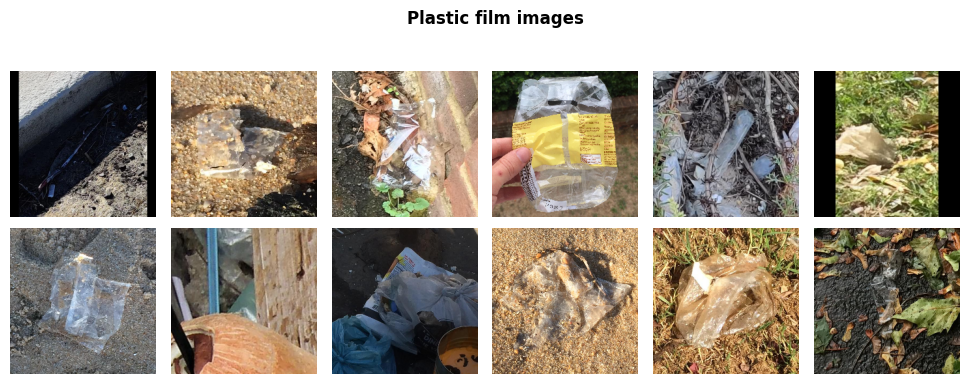

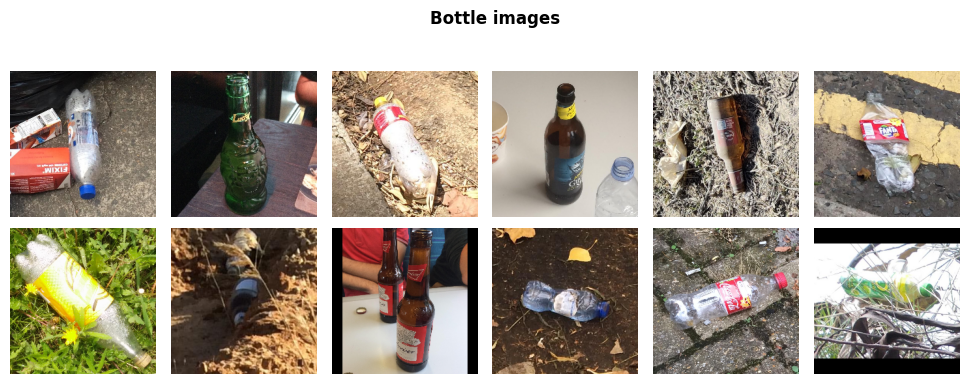

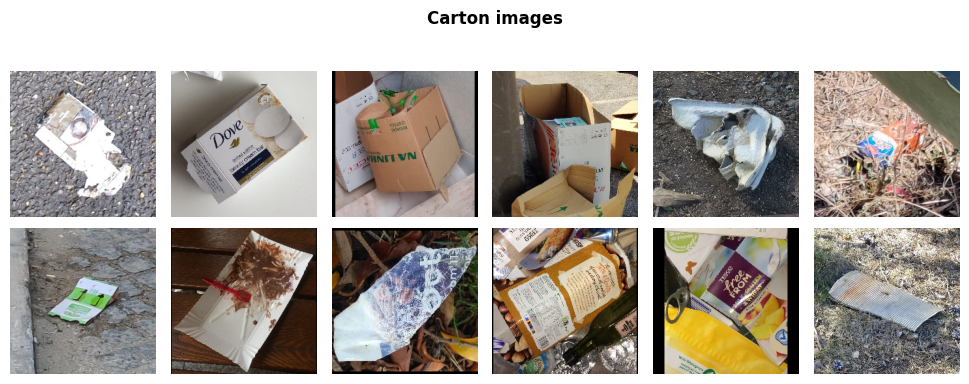

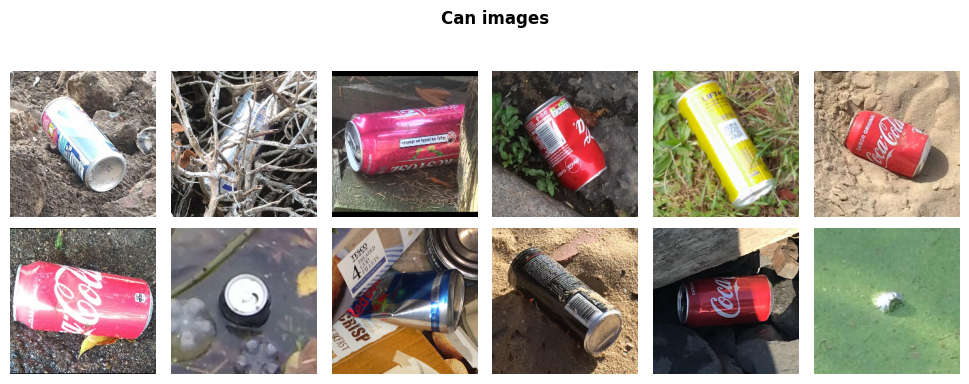

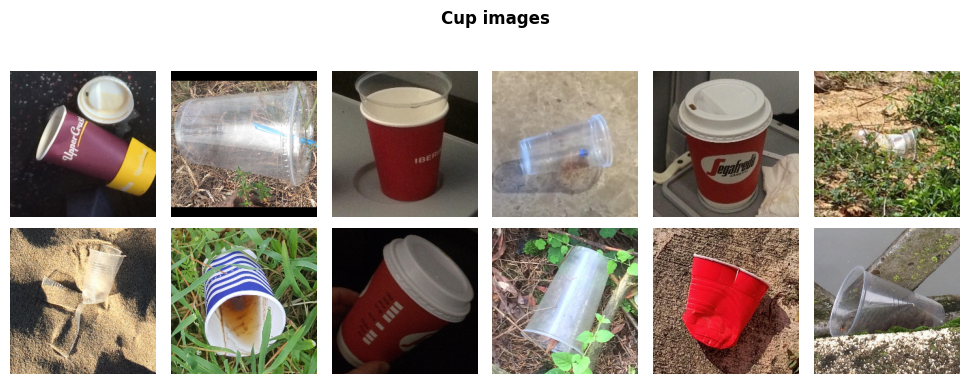

In [37]:
# Plotting function:
def plot_images_by_label(features, images, label, num_samples=12, nrows=2, ncols=6, figsize=(10, 4)):
    annotations_samples = sample(list(features.index[features.c1_label == label]), num_samples)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    for (annotindex, ax) in zip(annotations_samples, axes.flatten()):
        ax.imshow(images[annotindex, :, :, :])
        ax.set_axis_off()

    fig.suptitle(f"{label} images", fontsize=12, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 0.98, 0.98])
    plt.show()

# Example usage:
labels = ["Plastic film", "Bottle", "Carton", "Can", "Cup"]
for label in labels:
    plot_images_by_label(c1_features, c1_images, label=label)

## 5) Split out the testing set

After having balanced our dataset, we split it into a training/validation set (80%) and a testing set (20%). We choose to combine the training and validation set into one, because we will be applying 5-fold cross validation on the combined set later on.

In [38]:
# Separate features from labels
X = c1_features.drop(["c1_label","c1_numlabel","annotation_id"], axis=1)
ylab = c1_features["c1_label"]

In [39]:
# Split out data into a test test, and a training/validation set
from sklearn.model_selection import train_test_split

# Split data into training/validation and test sets
X_trainval, X_test, ylab_trainval, ylab_test = train_test_split(X, ylab, test_size=0.2, random_state=8, stratify=ylab)

# Concatenate features and labels for training/validation set
c1_trainval = pd.concat([ylab_trainval, X_trainval], axis=1)

# Convert to NumPy arrays
X_trainval, X_test = X_trainval.values, X_test.values
ylab_trainval, ylab_test = ylab_trainval.values, ylab_test.values

# Print shapes
print("X_trainval: {}, ylab_trainval: {}".format(X_trainval.shape, ylab_trainval.shape))
print("X_test: {}, ylab_test: {}".format(X_test.shape, ylab_test.shape))

X_trainval: (1248, 2048), ylab_trainval: (1248,)
X_test: (313, 2048), ylab_test: (313,)


We visualize the class distribution of the training/validation and testing sets and we are satisfied that these two samples are now balanced.

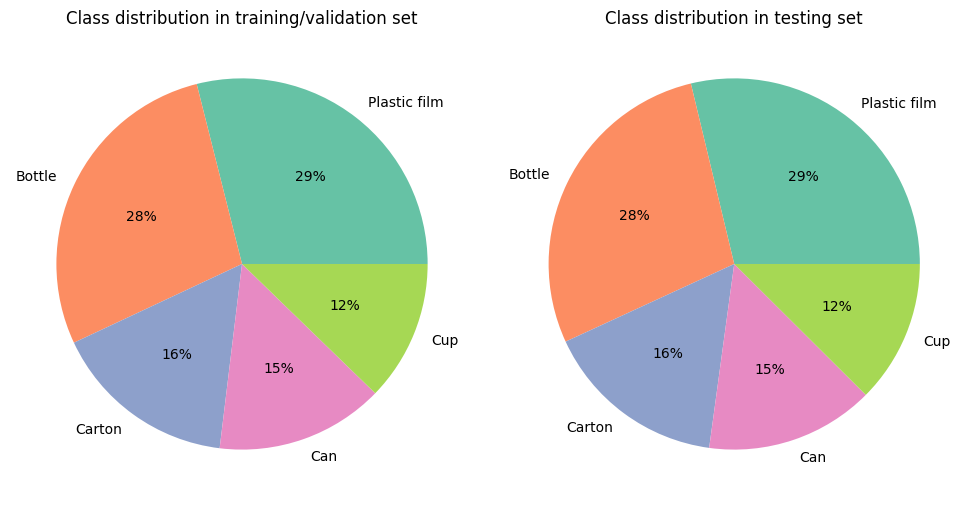

In [40]:
# Set the default figure size and enable automatic layout adjustment
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True

# Create subplots with pie charts for class distribution in training/validation set and testing set
plt.subplot(1, 2, 1)  # Subplot 1
plt.pie(pd.Series(ylab_trainval).value_counts(normalize=False), labels=pd.Series(ylab_trainval).value_counts(normalize=False).index, colors=piecolors, autopct='%.0f%%')
plt.title("Class distribution in training/validation set")  # Title for subplot 1

plt.subplot(1, 2, 2)  # Subplot 2
plt.pie(pd.Series(ylab_test).value_counts(normalize=False), labels=pd.Series(ylab_test).value_counts(normalize=False).index, colors=piecolors, autopct='%.0f%%')
plt.title("Class distribution in testing set")  # Title for subplot 2

plt.show()  # Display the subplots

# Restore the default plot settings
plt.rcParams.update(plt.rcParamsDefault)

## 6) Feature analysis and correlations

Next, we will run some exploratory data analysis on the 2,048 features created by the ResNet50V2 model.

In [41]:
# Convert the features to numeric
feature_column_names = c1_trainval.columns[c1_trainval.columns.str.startswith('feat')]
c1_trainval[feature_column_names] = c1_trainval[feature_column_names].apply(pd.to_numeric)

We can see that there are no missing values in these features and that the minimum value for all features is zero.

In [42]:
c1_trainval.describe()

feat_2048    feat_2047    feat_2046    feat_2045    feat_2044  \
count  1248.000000  1248.000000  1248.000000  1248.000000  1248.000000   
mean      0.449045     0.233518     0.343463     0.121105     0.339342   
std       0.769414     0.411388     0.582128     0.353349     0.730241   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.001442     0.000000     0.009020     0.000000     0.000000   
50%       0.122661     0.063602     0.117978     0.000000     0.067407   
75%       0.519199     0.263614     0.427493     0.078079     0.312862   
max       6.213694     4.775226     5.370518     4.189202     8.583287   

         feat_2043    feat_2042    feat_2041    feat_2040    feat_2039  ...  \
count  1248.000000  1248.000000  1248.000000  1248.000000  1248.000000  ...   
mean      0.315684     0.001098     2.222919     0.795406     0.471550  ...   
std       0.625367     0.002909     2.047276     1.395183     1.128518  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.694422     0.010836     0.000000  ...   
50%       0.062656     0.000000     1.625801     0.175591     0.055734  ...   
75%       0.365490     0.000629     3.217526     0.919013     0.424851  ...   
max       6.075846     0.029176    16.273739     9.792124    12.930611  ...   

           feat_10       feat_9       feat_8       feat_7       feat_6  \
count  1248.000000  1248.000000  1248.000000  1248.000000  1248.000000   
mean      0.177883     0.415353     0.280829     0.945880     0.000670   
std       0.461082     0.639375     0.585663     1.335936     0.003573   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.027667     0.000000     0.094653     0.000000   
50%       0.007846     0.182767     0.049880     0.432296     0.000000   
75%       0.129438     0.561803     0.311337     1.295104     0.000000   
max       6.208889     7.926932     6.174488    13.067119     0.049578   

            feat_5       feat_4       feat_3       feat_2       feat_1  
count  1248.000000  1248.000000  1248.000000  1248.000000  1248.000000  
mean      0.306319     0.110856     0.114874     0.224640     0.505627  
std       0.565790     0.261628     0.305190     0.398045     0.732636  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.029554  
50%       0.081381     0.004524     0.013150     0.070625     0.227286  
75%       0.361151     0.098661     0.086888     0.278474     0.633792  
max       5.243631     2.441783     3.103781     5.219564     5.353301  

[8 rows x 2048 columns]

The maximum value for the 2,048 features goes up to 30 for some features. Therefore, there is some variation in the range of our features. The 2,048 features often have a value of zero. In fact, from below, we can see that about 24% of features are majority-zero.

The heatmaps below diplay the values of those features for each class. We can see that some features (vertical lines) are more active in some classes compared to others, with consistently higher values across all samples.

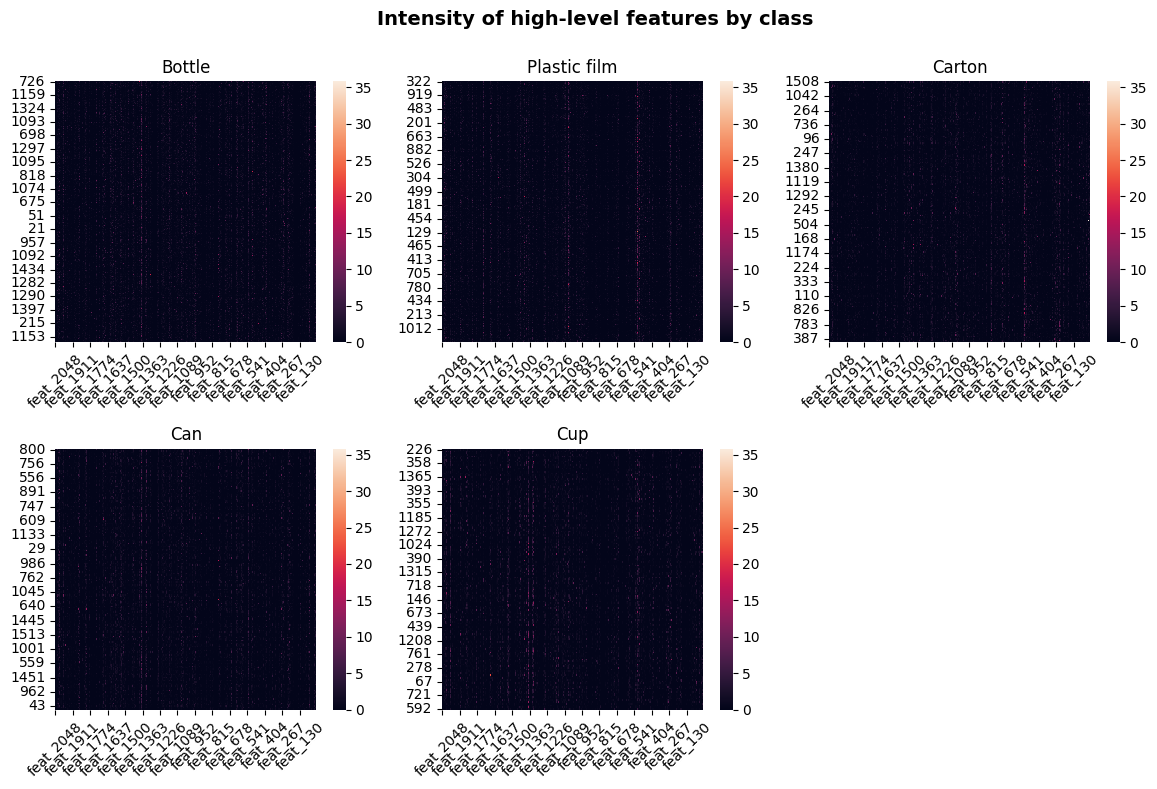

In [43]:
# Calculate the minimum and maximum values across all features for setting the color range
minrange = np.min(c1_trainval.describe().loc["min", :])
maxrange = np.max(c1_trainval.describe().loc["max", :])

# Create a grid of subplots for each class
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over each class and its corresponding axis in the subplot grid
for (var, ax) in zip(['Bottle', 'Plastic film', 'Carton', 'Can', 'Cup'], axes.flatten()):
    # Create a heatmap for the features of the current class
    sns.heatmap(ax=ax, data=c1_trainval.loc[c1_trainval.c1_label == var, c1_trainval.columns.str.startswith("feat")], vmin=minrange, vmax=maxrange)
    # Set the title for the current subplot with the class name
    ax.set_title(var)
    # Rotate x-axis labels for better readability and adjust their size
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)

# Hide the empty subplot in the bottom-right corner
axes[1, 2].set_visible(False)

# Set a main title for the entire figure
fig.suptitle("Intensity of high-level features by class", fontsize=14, fontweight="bold")

# Adjust layout to prevent overlap of titles and subplots
plt.tight_layout(rect=[0, 0, 0.98, 0.98])

# Display the plot
plt.show()

## 7) PCA analysis

Next, we will run a principal component analysis on the 2,048 features. Running our machine learning models using a limited number of principal components, rather than the whole set of features, might be a useful way to reduce dimensionality while using variables that retain the variation across the entire feature space.

In [44]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [45]:
# Define a feature engineering pipeline
feature_engineering = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
        ("pca", PCA())  # Apply Principal Component Analysis (PCA) for dimensionality reduction
    ]
)

The first 50 principal components explain 42% of the total variance and the first one just over 3% - which suggests that our original features may not be highly correlated with each other.

In [46]:
# Create the PCs for our training/validation predictors
X_trainval_pcs = feature_engineering.fit_transform(X_trainval)

In [47]:
# Extract the explained variance ratios from the PCA step of the feature engineering pipeline
pve = feature_engineering.named_steps["pca"].explained_variance_ratio_

# Calculate and print the variance explained by the first principal component
variance_explained_first_pc = pve[0]  # Variance explained by the first principal component

# Calculate and print the cumulative explained variance for the first 50 principal components
cumulative_var_50 = np.cumsum(pve)[49]  # Cumulative explained variance for the first 50 components

# Print informative messages about the variance explained by the first principal component and the cumulative explained variance
print("Variance explained by the first principal component: {:.2%}".format(variance_explained_first_pc))
print("Cumulative explained variance for the first 50 principal components: {:.2%}".format(cumulative_var_50))

Variance explained by the first principal component: 3.76%
Cumulative explained variance for the first 50 principal components: 41.56%


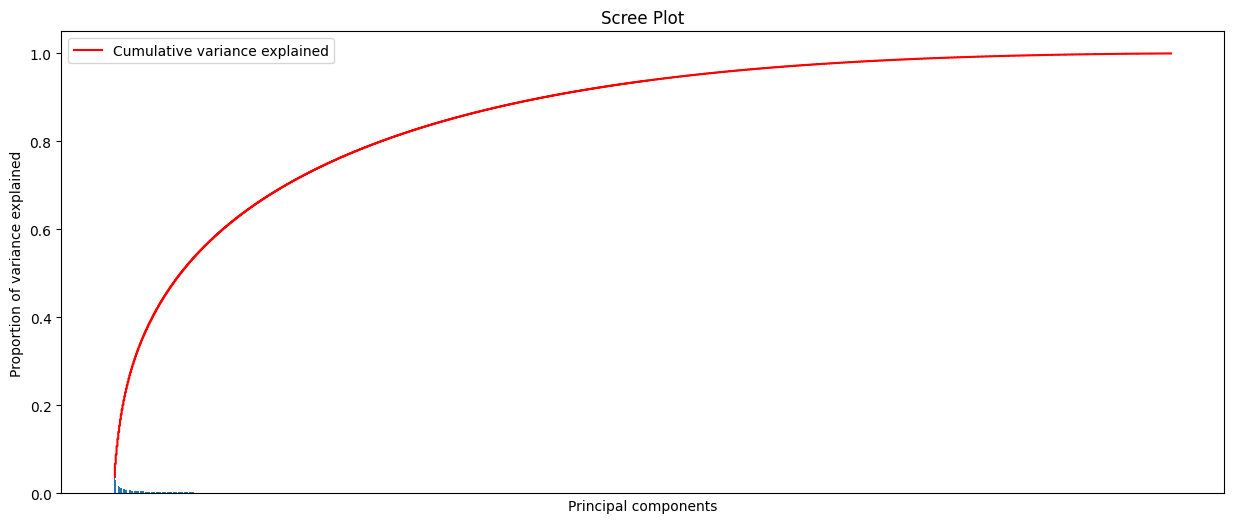

In [48]:
# Figure size
plt.figure(figsize=(15,6))

# Create bar plot
xcor = np.arange(1, len(pve) + 1)  # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor)

# Add cumulative sum
plt.step(xcor + 0.5,np.cumsum(pve),label="Cumulative variance explained",color='red')

# Add labels
plt.xlabel("Principal components")
plt.xticks([])
plt.ylabel("Proportion of variance explained")
plt.title('Scree Plot')
plt.legend()
plt.show()

## 8) Baseline model

Our baseline performance metric will be the percentage of samples correctly predicted if we predict the most frequent class for all samples.

In [49]:
# Import the DummyClassifier class from scikit-learn
from sklearn.dummy import DummyClassifier

# Create a dummy classifier object with 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=1)

# Train the dummy classifier on the training/validation data
dummy_clf.fit(X_trainval, ylab_trainval)

# Calculate and print the accuracy score of the dummy classifier on the test data
accuracy_score = dummy_clf.score(X_test, ylab_test)

# Print an informative message about the accuracy score
print("Accuracy score of the dummy classifier on the test data: {:.2%}".format(accuracy_score))

Accuracy score of the dummy classifier on the test data: 28.75%


## 9) k-NN model

Our first machine learning model will be K nearest neighbours (k-NN). We choose a k-NN model because it is relatively simple to implement, but it can also classify data that is not linearly separable in the feature space.

A drawback of the k-NN model is that, with a high number of features (e.g. over 2,000), the distance metric used in k-NN can become irrelevant. Indeed, all samples will tend to have a similar distance to each other in a space with a high number of dimensions.

### Model set-up

In [50]:
# Import necessary modules from scikit-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define a pipeline for K-Nearest Neighbors (k-NN) classifier
knn_estimator = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
        ("knn", KNeighborsClassifier()),  # K-Nearest Neighbors classifier
    ]
)

# Display the parameters of the k-NN classifier
knn_estimator.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

### Grid search with cross-validation to find optimal hyper-parameters

We need to find the optimal value for our hyperparameter, the number of neighbours (k). We will select hyperparameter that maximizes the mean accuracy on the validation sets.

In [51]:
# Define the grid of hyperparameters for grid search
grid = {
    "knn__n_neighbors": list(range(1, 30+1)),  # Number of neighbors to consider (1 to 30)
}

# Create a grid search object for KNN classifier
knn_random_search = GridSearchCV(
    knn_estimator,  # Pipeline containing the estimator and preprocessing steps
    cv=5,  # Number of folds for cross-validation
    param_grid=grid,  # Grid of hyperparameters to search over
    return_train_score=True,  # Return training scores
    refit=True,  # Refit the best model on the entire training/validation set
    verbose=True,  # Print progress messages
    n_jobs=-1  # Use all available CPU cores for parallel computation
)

# Perform grid search to find the best hyperparameters
knn_random_search.fit(X_trainval, ylab_trainval)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30]},
             return_train_score=True, verbose=True)

The highest accuracy is achieved with 2 neighbours.

In [52]:
# Best parameters
knn_random_search.best_params_

{'knn__n_neighbors': 2}

In [53]:
# These are the metrics computer during the grid search 
knn_random_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [54]:
# Create a DataFrame to store the results of hyperparameter search for KNN
knn_param_search_results = pd.DataFrame(
    {
        "k": knn_random_search.cv_results_["param_knn__n_neighbors"],  # Number of neighbors (k)
        "mean_tr": knn_random_search.cv_results_["mean_train_score"],  # Mean training score
        "std_tr": knn_random_search.cv_results_["std_train_score"],  # Standard deviation of training score
        "mean_val": knn_random_search.cv_results_["mean_test_score"],  # Mean validation score
        "std_val": knn_random_search.cv_results_["std_test_score"]  # Standard deviation of validation score
    }
)

# Display the top 10 results based on mean validation score
top_10_results = knn_param_search_results.sort_values(by="mean_val", ascending=False)[:10]
top_10_results

k   mean_tr    std_tr  mean_val   std_val
1   2  0.887221  0.010109  0.643451  0.020042
2   3  0.766825  0.007745  0.627451  0.025168
0   1  1.000000  0.000000  0.623418  0.015302
3   4  0.760614  0.009885  0.621815  0.022140
4   5  0.721951  0.013455  0.619431  0.024593
5   6  0.701520  0.012742  0.611418  0.027183
6   7  0.676878  0.014766  0.600215  0.029509
7   8  0.661454  0.015093  0.596215  0.033308
8   9  0.639818  0.017824  0.581783  0.030594
9  10  0.625999  0.015398  0.576973  0.030815

The training score decreases gradually as the number of neighbors (k) increases, starting from a perfect fit at k=1. However, the validation score exhibits diminishing returns with higher complexity (k), indicating potential overfitting, which suggests the model's performance may not benefit significantly from additional neighbors beyond a certain point.

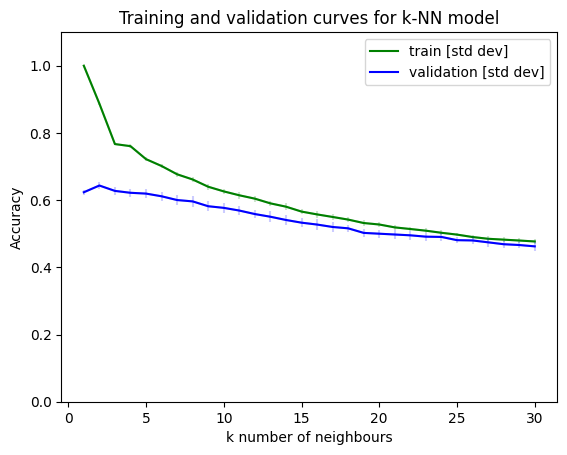

In [55]:
# Plot mean training scores
plt.plot(knn_param_search_results["k"],knn_param_search_results["mean_tr"],label="train [std dev]", color="green")
plt.errorbar(knn_param_search_results["k"],knn_param_search_results["mean_tr"], yerr=knn_param_search_results["std_tr"]*0.5, color="green", alpha=0.2)

# Plot mean validation scores
plt.plot(knn_param_search_results["k"],knn_param_search_results["mean_val"],label="validation [std dev]", color="blue")
plt.errorbar(knn_param_search_results["k"],knn_param_search_results["mean_val"], yerr=knn_param_search_results["std_val"]*0.5, color="blue", alpha=0.2)

#Titles and labels
plt.title("Training and validation curves for k-NN model")
plt.ylabel("Accuracy")
plt.xlabel("k number of neighbours")
plt.ylim(0,1.1)
plt.legend()
plt.show()

### Assess performance on the test set

Finally, we assess the performance of our tuned k-NN model on the testing set, which was set apart at the beginning.

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def get_report(truelabels, predlabels):
    """
    Generates and prints a classification report based on true and predicted labels.

    Parameters:
    truelabels (array-like): True labels.
    predlabels (array-like): Predicted labels.
    """
    print(classification_report(y_true=truelabels, y_pred=predlabels))

def get_confusion_matrix(truelabels, predlabels):
    """
    Plots the confusion matrix based on true and predicted labels.

    Parameters:
    truelabels (array-like): True labels.
    predlabels (array-like): Predicted labels.
    """
    # Get unique labels in the test set
    cm_test_labels = pd.Series(truelabels).value_counts().index
    # Generate confusion matrix display
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_true=truelabels, y_pred=predlabels, labels=cm_test_labels),
        display_labels=cm_test_labels
    )
    # Plot confusion matrix
    disp.plot()
    plt.show()

# Get predictions on the test set using the trained model
test_set_predictions = knn_random_search.predict(X_test)

The overall accuracy of the model is 64%, but we can see some variation in how the model performs for different classes.

Overall, the model performs reasonably well across different classes, with particularly strong performance on "Bottle" and "Plastic film" classes, while showing room for improvement, especially on "Can" and "Cup" classes where precision and recall are relatively lower.

In [57]:
get_report(ylab_test, test_set_predictions)

              precision    recall  f1-score   support

      Bottle       0.66      0.81      0.72        88
         Can       0.66      0.46      0.54        46
      Carton       0.62      0.50      0.56        50
         Cup       0.52      0.28      0.37        39
Plastic film       0.61      0.76      0.67        90

    accuracy                           0.63       313
   macro avg       0.61      0.56      0.57       313
weighted avg       0.62      0.63      0.61       313



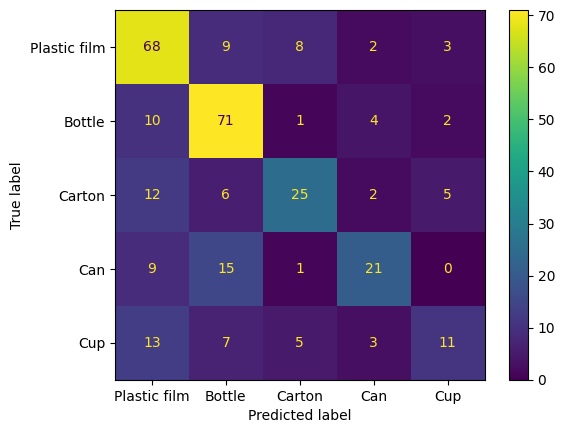

In [58]:
get_confusion_matrix(ylab_test, test_set_predictions)

Finally, we produce a receiver operating characteristic (ROC) curve for this model. Because this is a multiclass problem, we produce a [multiclass ROC curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) by micro-averaging, or aggregating, the contributions from all classes.

These ROC curves will be particularly useful for comparing different models: those models who reach the most top-left point in the ROC curve can produce predictions with a high true positive rate and a low false positive rate.

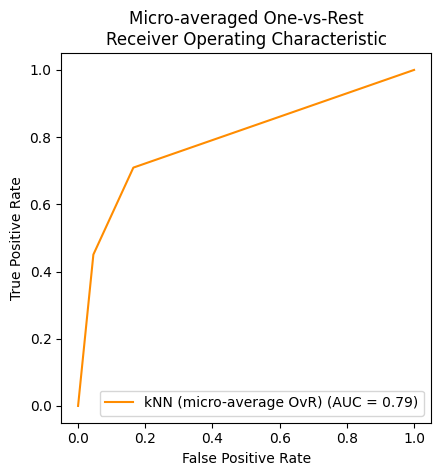

In [59]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

# Fit LabelBinarizer to training labels and transform test labels to one-hot encoded format
label_binarizer = LabelBinarizer().fit(ylab_trainval)
y_onehot_test = label_binarizer.transform(ylab_test)

# Generate ROC curve display using micro-average one-vs-rest strategy
knn_roc = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    knn_random_search.predict_proba(X_test).ravel(),
    name="kNN (micro-average OvR)",
    color="darkorange"
)

# Set plot properties
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

## 10) Logistic model

Having proposed and tuned a k-NN model, we try to classify our samples using a logistic model using the 'one vs. rest' approach. This means that we are performing 5 different logistic regressions, or one for each class. For example, in the regression for class="Bottle" we encode the outcome variable as 1="is bottle" and 0="is not bottle". When it comes to prediction, we predict the class wih the highest predicted likelihood for the positive class.

We include an L2 penalty term, which is controlled by hyper-parameter C and prevents the model coefficients from becoming too large - a sign of overfitting.

The parameter class_weight='balanced' in the logistic regression model assigns weights to each class inversely proportional to their respective frequencies in the training data. This means that classes with fewer instances will be given higher weight, while classes with more instances will be given lower weight, thereby balancing the influence of each class during model training. It helps to mitigate the impact of class imbalance, ensuring that the model does not disproportionately favor the majority class and improving its ability to generalize to minority classes.

### Model set-up

In [60]:
from sklearn.linear_model import LogisticRegression

# Define a pipeline for logistic regression model
logreg_estimator = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize features
        ("logreg", LogisticRegression(multi_class='ovr', penalty="l2", class_weight='balanced', solver='lbfgs', max_iter=1000))  # Logistic regression model with one-vs-rest strategy, L2 penalty, and balanced class weights
    ]
)

# Display the parameters of the logistic regression estimator
logreg_estimator.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('logreg',
   LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'logreg': LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'logreg__C': 1.0,
 'logreg__class_weight': 'balanced',
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 1000,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'lbfgs',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False}

### Grid search with cross-validation to find optimal hyper-parameters

We perform grid search with cross-validation to find the optimal value of C.

In [61]:
from sklearn.model_selection import GridSearchCV

# Define a range of values for the regularization parameter C
C_vals = np.logspace(-4, 6, num=30)

# Define the grid search parameters
grid = {
    "logreg__C": C_vals  # Regularization parameter C for logistic regression
}

# Initialize and fit GridSearchCV to find the best hyperparameters for logistic regression
logistic_gscv = GridSearchCV(
    estimator=logreg_estimator,  # Logistic regression estimator
    param_grid=grid,  # Grid of hyperparameters to search
    cv=5,  # 5-fold cross-validation
    refit=True,  # Refit the best model on the entire training set
    return_train_score=True,  # Return training scores
    verbose=True,  # Print detailed messages
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

# Fit the GridSearchCV object on the training data
logistic_gscv.fit(X_trainval, ylab_trainval)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='ovr'))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.00000000e-04, 2.21221629e-04, 4.89390092e-04, 1.08263673e-03,
       2.39502662e-03, 5.29831691e-03, 1.17210230e-02, 2.59294380e-02,
       5.73615251e-02, 1.26896100e-01, 2.80721620e-01, 6.21016942e-01,
       1.37382380e+00, 3.03919538e+00, 6.72335754e+00, 1.48735211e+01,
       3.29034456e+01, 7.27895384e+01, 1.61026203e+02, 3.56224789e+02,
       7.88046282e+02, 1.74332882e+03, 3.85662042e+03, 8.53167852e+03,
       1.88739182e+04, 4.17531894e+04, 9.23670857e+04, 2.04335972e+05,
       4.52035366e+05, 1.00000000e+06])},
             return_train_score=True, verbose=True)

In [62]:
# Retrieve the best logistic regression estimator from the GridSearchCV results
logistic_gscv.best_estimator_["logreg"]

LogisticRegression(C=0.011721022975334805, class_weight='balanced',
                   max_iter=1000, multi_class='ovr')

We can see from our grid search with cross validation that the value of C that maximises the validation accuracy is approximately 0.01.

From our validation curve, we can see that with high values of C (meaning less regularization) the model tends to overfit with an accuracy of 100% on the training set but under 80% on the validation set.

In [63]:
# Create a DataFrame to store logistic regression cross-validation results
logreg_results = pd.DataFrame(
    {
        "C": logistic_gscv.cv_results_["param_logreg__C"],  # Regularization parameter C
        "mean_tr": logistic_gscv.cv_results_["mean_train_score"],  # Mean training score
        "std_tr": logistic_gscv.cv_results_["std_train_score"],  # Standard deviation of training scores
        "mean_val": logistic_gscv.cv_results_["mean_test_score"],  # Mean validation score
        "std_val": logistic_gscv.cv_results_["std_test_score"]  # Standard deviation of validation scores
    }
)

# Display the top 5 models based on mean validation score
logreg_results.sort_values(by="mean_val", ascending=False)[:5]

C   mean_tr    std_tr  mean_val   std_val
6  0.011721  0.999199  0.000401  0.770840  0.015777
4  0.002395  0.962741  0.002921  0.770837  0.022938
2  0.000489  0.882212  0.003808  0.770821  0.020907
3  0.001083  0.926283  0.003425  0.770027  0.027595
5  0.005298  0.992188  0.002137  0.768447  0.019633

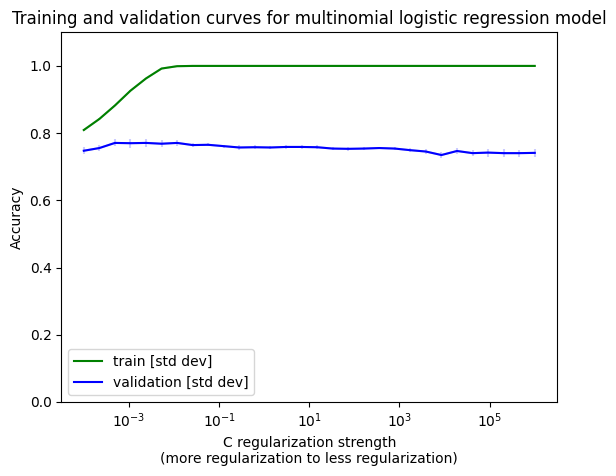

In [64]:
# Plot mean training scores
plt.semilogx(logreg_results["C"],logreg_results["mean_tr"],label="train [std dev]", color="green")
plt.errorbar(logreg_results["C"],logreg_results["mean_tr"], yerr=logreg_results["std_tr"]*0.5, color="green", alpha=0.2)

# Plot mean validation scores
plt.semilogx(logreg_results["C"],logreg_results["mean_val"],label="validation [std dev]", color="blue")
plt.errorbar(logreg_results["C"],logreg_results["mean_val"], yerr=logreg_results["std_val"]*0.5, color="blue", alpha=0.2)

#Titles and labels
plt.title("Training and validation curves for multinomial logistic regression model")
plt.ylabel("Accuracy")
plt.xlabel("C regularization strength\n(more regularization to less regularization)")
plt.ylim(0,1.1)
plt.legend()
plt.show()

### Assess performance on the test set

Now, we can assess the performance on the test set. The model generally performs well across all classes, with varying degrees of precision, recall, and F1-score for each class. "Bottle" and "Plastic film" classes tend to have higher precision, recall, and F1-score values, indicating better performance in correctly identifying instances of these classes. However, the "Carton" class has comparatively lower precision, recall, and F1-score values, suggesting some difficulty in correctly classifying instances belonging to this class.

In [65]:
# Predict classes on the test set
test_set_predictions = logistic_gscv.predict(X_test)

In [66]:
# Get classification report
get_report(ylab_test, test_set_predictions)

              precision    recall  f1-score   support

      Bottle       0.76      0.84      0.80        88
         Can       0.74      0.63      0.68        46
      Carton       0.59      0.64      0.62        50
         Cup       0.70      0.59      0.64        39
Plastic film       0.70      0.69      0.69        90

    accuracy                           0.70       313
   macro avg       0.70      0.68      0.69       313
weighted avg       0.70      0.70      0.70       313



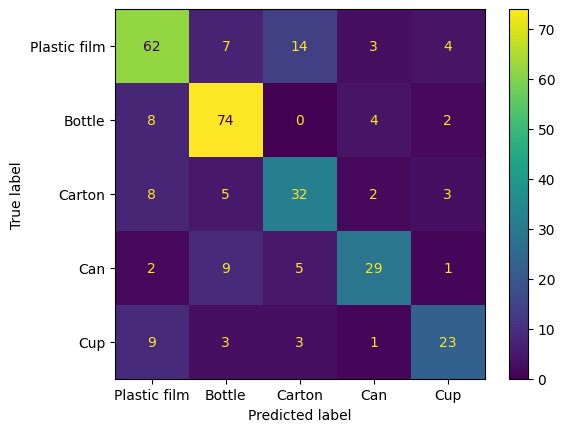

In [67]:
# Get confusion matrix
get_confusion_matrix(ylab_test, test_set_predictions)

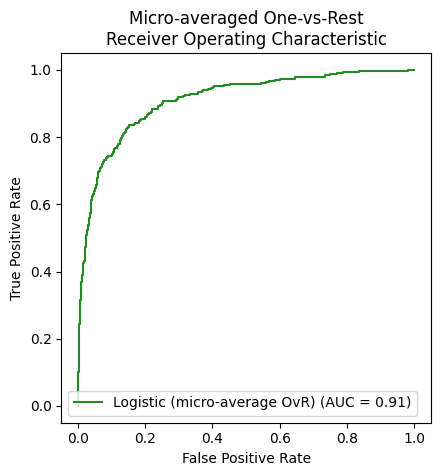

In [68]:
# Plotting ROC curve using RocCurveDisplay
logistic_roc = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),  # True labels in one-hot encoded format
    logistic_gscv.predict_proba(X_test).ravel(),  # Predicted probabilities from the logistic regression model
    name="Logistic (micro-average OvR)",  # Name of the plot
    color="forestgreen"  # Color of the plot
)

# Setting plot properties
plt.axis("square")  # Setting aspect ratio to square
plt.xlabel("False Positive Rate")  # X-axis label
plt.ylabel("True Positive Rate")  # Y-axis label
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")  # Title of the plot
plt.legend()  # Displaying legend
plt.show()  # Showing the plot

## 11) Model comparison

Finally we can compare the performance of our two models and our baseline.

In terms of accuracy, both models perform better than the baseline (29%). Looking at the accuracy and the ROC curves, we can see that the logistic model (70% accurate) out-performs the k-NN model (64% accurate) on the test set.

In [69]:
# Creating a dictionary to store the model names and their corresponding test accuracies
final_comparison = {
    'k-NN': [knn_random_search.score(X_test, ylab_test)],  # Accuracy score for kNN model
    'Logistic regression': [logistic_gscv.score(X_test, ylab_test)],  # Accuracy score for logistic regression model
    'Baseline (most frequent)': [dummy_clf.score(X_test, ylab_test)]}  # Accuracy score for the baseline model

# Converting the dictionary to a DataFrame, transposing it, and setting the index as "accuracy"
final_comparison = pd.DataFrame(final_comparison, index=["accuracy"]).transpose()

# Sorting the DataFrame by accuracy score in ascending order
final_comparison.sort_values(by="accuracy", inplace=True)

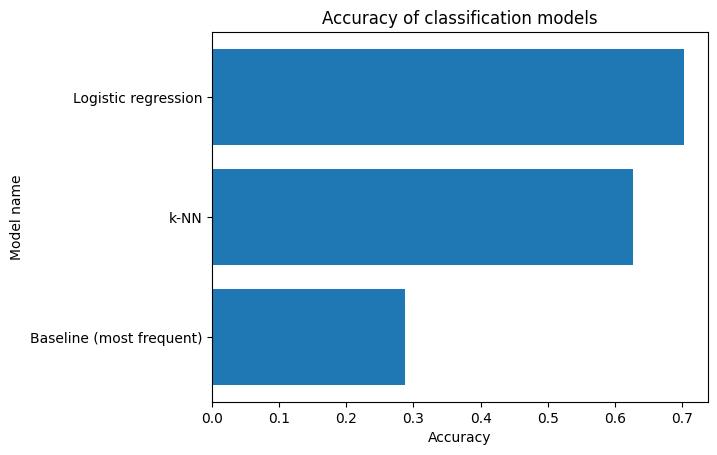

In [70]:
# Creating a horizontal bar plot to visualize the accuracy of classification models
plt.barh(width=final_comparison.accuracy, y=final_comparison.index)

# Adding title and axis labels
plt.title("Accuracy of classification models")
plt.ylabel("Model name")
plt.xlabel("Accuracy")

# Displaying the plot
plt.show()

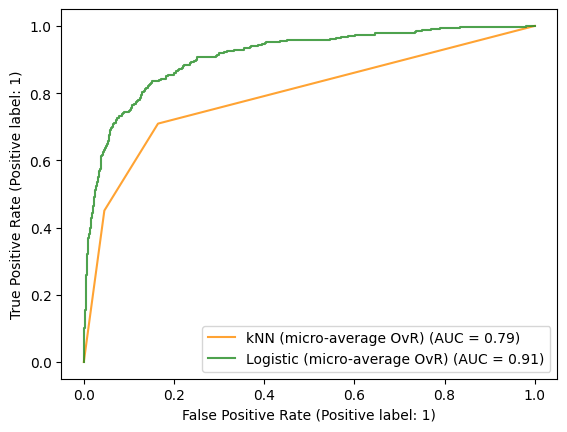

In [71]:
# Get the current Axes instance
ax = plt.gca()

# Plotting the ROC curves for kNN and logistic regression models on the same Axes
knn_roc.plot(ax=ax, alpha=0.8, color="darkorange")
logistic_roc.plot(ax=ax, alpha=0.8, color="forestgreen")

# Display the plot
plt.show()

# Segmenting images

Image segmentation is the process of partitioning an image into multiple segments or regions. The goal of segmentation is to simplify the representation of an image into meaningful parts, which can then be analyzed individually. This technique is commonly used in computer vision tasks for various applications such as object detection, recognition, and scene understanding.

In this notebook, we aim to segment images featuring individual bottles, focusing on identifying and delineating the contours of each bottle within the image.

## 1) Load packages

We start by loading a standard set of Python libraries, and install and load [keras_unet](https://github.com/karolzak/keras-unet), a package for image segmentation tasks with a number of useful helper functions.

In [72]:
# Install keras_unet package
!pip install keras_unet

In [73]:
# Import keras_unet package, to be used for image segmentation
import keras_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## 2) Load data for segmentation model

Next, we load the images and masks for the images of bottles we set aside in notebooks 1 and 2.

We use the images created with **widen_param=0.05**, meaning that our objects will be in the **center of the image** but we retain some of the **image background** beyond the annotation bounding box. As a reminder, we also restricted the sample to images with **only one bottle**. Therefore, the model will not encounter any images containing two or more objects to segment.

In [74]:
# Load the processed (cropped+framed) images
with np.load("{}/{}/{}".format(features_path,"widen_param_0.05","classification-images.npz"), allow_pickle=True) as npz_file:
    # It's a dictionary-like object
    print(list(npz_file.keys()))

    # Load the arrays
    s1_images = npz_file["s1"]
    s1_masks = npz_file["s1_masks"]

['c1', 's1', 's1_masks']


## 3) Plotting images (X) and masks (Y)

The image masks have the same shape as the corresponding images (224x224 pixels), and each pixel has either a value of 0 (if it's outside of the object) or 1 (if it's inside of the object). A key difference is that our images are in colour (and therefore have three colour channels) whereas the masks only have one colour channel or dimension.

We rescale the images so the value in each image pixel is between 0 and 1, and set set the data type for the masks to integers.

In [75]:
# Pre-process masks and images
s1_masks = s1_masks.astype(np.uint8)
s1_images = s1_images*1./255.

In [76]:
"Shape of images array: {}, Shape of masks array: {}".format(s1_images.shape,s1_masks.shape)

'Shape of images array: (248, 224, 224, 3), Shape of masks array: (248, 224, 224, 1)'

Then we plot 10 images from our set using the plot_imgs function, showing the original image and its mask side by side. We also show the overlay, with the mask on top of the original image. This is a useful sense check, to verify that our images and masks have been processed properly.

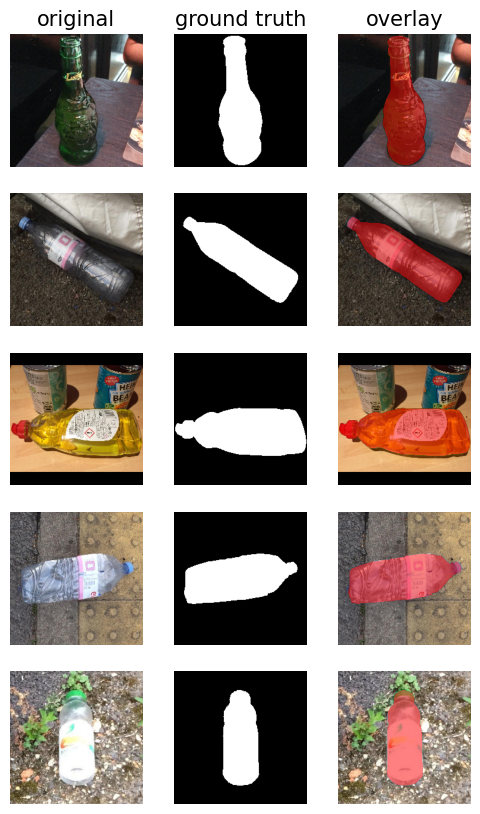

In [77]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=s1_images, mask_imgs=s1_masks, nm_img_to_plot=5, figsize=2)

## 4) Splitting data into train, validation and test sets

In these models, our predictors (X) will be the images and the outcome (Y) will be the image masks. As opposed to our previous classification problems, here we will be making predictions at the _pixel_ level rather than at the image level. Indeed, we are predicting whether each pixel is located inside the bottle (Y=1) or outside the bottle (Y=0).

First, we split the data into two sets: a combined training/validation set (90%) and a test set (10%). Then, we split the combined training/validation set into training (80%) and validation sets (20%). The resulting training set has 178 images, the validation set has 45 images and the testing set has 25 images.

In [78]:
from sklearn.model_selection import train_test_split

# Split data into training/validation sets and a test set
x_trainval, x_test, y_trainval, y_test = train_test_split(
    s1_images, s1_masks, test_size=0.1, random_state=8)

# Further split the training/validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_trainval, y_trainval, test_size=0.2, random_state=8)

# Convert to tensorflow type tf.float32
x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)
x_val = tf.cast(x_val, tf.float32)
y_val = tf.cast(y_val, tf.float32)

# Print the shapes of the resulting datasets
print("x_test: {}, y_test: {}".format(x_test.shape, y_test.shape))
print("x_train: {}, y_train: {}".format(x_train.shape, y_train.shape))
print("x_val: {}, y_val: {}".format(x_val.shape, y_val.shape))

x_test: (25, 224, 224, 3), y_test: (25, 224, 224, 1)
x_train: (178, 224, 224, 3), y_train: (178, 224, 224, 1)
x_val: (45, 224, 224, 3), y_val: (45, 224, 224, 1)


## 5) Setting up a convolutional neural network for image segmentation

In [79]:
# Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

We specify a convolutional neural network with a U-net architecture for our segmentation task, drawing from a [tutorial](https://www.machinelearningnuggets.com/image-segmentation-with-u-net-define-u-net-model-from-scratch-in-keras-and-tensorflow/) on image segmentation using Keras written by Derrick Mwiti.

- First, the model receives an input image of size 224x224x3, with the third dimension representing the three colour channels.

- Then, there is a contraction path which involves downsampling the input image and extracting increasingly abstract features. The number of filters in each block goes from 16 to 256. Between each block, a Max Pooling operation with stride 2 reduces the spatial resolution by half.

 - Traditional convolutional neural networks with pooling layers and dense layers are not suitable for image segmentation tasks because they discard **spatial information**, which is important to identify *where* objects are located in an image. U-Net models, however, are designed to preserve spatial information by upsampling the image, which enables the model to capture *where* objects might be located.

- Following the contraction path, the expansive path involves upsampling the features back to the original image size using transposed convolutions. Finally, a sigmoid activation function generates the binary segmentation mask.

In [80]:
# Define the convolutional block
def conv_block(x, filters):
    # Convolutional layer with ReLU activation and He normal weight initialization
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    # Dropout layer with dropout rate of 0.1
    x = tf.keras.layers.Dropout(0.1)(x)
    # Convolutional layer with ReLU activation and He normal weight initialization
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    # Batch normalization layer
    x = tf.keras.layers.BatchNormalization()(x)
    # ReLU activation layer
    x = tf.keras.layers.ReLU()(x)
    return x

# Define the up-convolutional block
def upconv_block(x, skip, filters):
    # Transposed convolutional layer (up-convolution) with stride of 2x2 and padding to maintain the spatial dimensions
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    # Concatenate the up-convolved feature maps with the skip connection from the contracting path
    x = tf.keras.layers.concatenate([x, skip])
    # Batch normalization layer
    x = tf.keras.layers.BatchNormalization()(x)
    # ReLU activation layer
    x = tf.keras.layers.ReLU()(x)
    return x

# Define the input layer
inputs = tf.keras.layers.Input((224, 224, 3))

# Contraction path
c1 = conv_block(inputs, 16)  # First convolutional block with 16 filters
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)  # Second convolutional block with 32 filters
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)  # Third convolutional block with 64 filters
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)  # Fourth convolutional block with 128 filters
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)  # Fifth convolutional block with 256 filters

# Expansive path
u6 = upconv_block(c5, c4, 128)  # First up-convolutional block with 128 filters
u7 = upconv_block(u6, c3, 64)   # Second up-convolutional block with 64 filters
u8 = upconv_block(u7, c2, 32)   # Third up-convolutional block with 32 filters
u9 = upconv_block(u8, c1, 16)   # Fourth up-convolutional block with 16 filters

# Output
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(u9)

# Define the U-Net model
unet_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

## 6) Data augmentation

We will use the 'get_augmented' function from the keras_unet package to artificially augment our training data. By generating "new" images, data augmentation can improve the model's performance and generalizability. This helps the model learn more robust representations of the data and reduce overfitting.

In [81]:
# Create an augmented images generator for the training set
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train,
    batch_size=3,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

Our augmented images generator output three images at a time, and we plot a sample of those augmented images to check that the spatial relationships in the masks have been preserved.

In [82]:
# Plot a sample of augmented training images
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=3, figsize=2)

(3, 224, 224, 3) (3, 224, 224, 1)


## 7) Fitting our model

### The IOU metric

The intersection-over-union (IoU) metric is a widely used metric to assess the performance of an image segmentation model. It measures the overlap between the predicted segmentation mask and the ground truth mask for an image. IoU ranges from 0 to 1, with 0 meaning no overlap and 1 meaning a perfect overlap.

![iou](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_examples.png?lossy=2&strip=1&webp=1)

*Adrian Rosebrock, "Intersection over union for object detection" ([link](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/))*

### Compiling and fitting the model

In [83]:
# Import functions
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded

Using a model checkpoint, we will save the model weights each time the thresholded IOU improves on the validation set images.

In [84]:
# Directory for saved models
saved_models_path = os.path.join(parent_directory,'saved_models')
os.makedirs(saved_models_path, exist_ok=True)

In [85]:
# Create a checkpoint for our U-net model
model_path = "{}/{}/{}".format(saved_models_path,"widen_param_0.05","segm_model.keras")

callback_checkpoint = ModelCheckpoint(
    model_path,
    verbose=1,
    monitor='val_iou_thresholded',
    mode='max',
    save_best_only=True,
)

We will use a binary cross-entropy loss function, since this is a pixel-level binary classification problem.

Our data generator provides the model with training data in batches, with each batch consisting of three input images and masks. Our generator provides 300 batches per epoch, and the model is trained for 25 epochs. As a reminder, there are 178 images in the training set, so each epoch will see at least one version of each image. This allows the model to slowly improve its performance over 25 iterations.

In [86]:
# Compile model
unet_model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

We set a random seed for maximum reproducibility.

In [87]:
# Set seed
tf.keras.utils.set_random_seed(1)

Finally, we fit our convolutional neural network with a U-net architecture.

In [88]:
# Change format of training image generator
train_generator = (pair for pair in train_gen)

In [89]:
# Fit model
history = unet_model.fit(
    train_generator,
    steps_per_epoch=300,
    validation_data=(x_val, y_val),
    epochs=25,
    callbacks=[callback_checkpoint],
    verbose=1
)

Epoch 1/25
  4/300 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - iou: 0.1642 - iou_thresholded: 0.1696 - loss: 0.8449

I0000 00:00:1715804840.875506      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - iou: 0.2712 - iou_thresholded: 0.4069 - loss: 0.4658
Epoch 1: val_iou_thresholded improved from -inf to 0.46384, saving model to /kaggle/saved_models/widen_param_0.05/segm_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 150ms/step - iou: 0.2715 - iou_thresholded: 0.4072 - loss: 0.4652 - val_iou: 0.3358 - val_iou_thresholded: 0.4638 - val_loss: 0.3211
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - iou: 0.4170 - iou_thresholded: 0.5501 - loss: 0.2754
Epoch 2: val_iou_thresholded improved from 0.46384 to 0.53630, saving model to /kaggle/saved_models/widen_param_0.05/segm_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - iou: 0.4171 - iou_thresholded: 0.5502 - loss: 0.2754 - val_iou: 0.3669 - val_iou_thresholded: 0.5363 - val_loss: 0.2708
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - iou: 0.4885 - iou_thresholded: 0.6169 - loss: 0.2339
Epoch 3: val_iou_thresholded improved from 0.53630 to 0.56403, saving model to /kaggle/sav

In [90]:
# Path to save model history
history_path = "{}/{}/{}".format(saved_models_path,"widen_param_0.05","segm_model_history.csv")

# Save model history
with open(history_path, mode='w') as f:
    pd.DataFrame(history.history).to_csv(f)

By the 25th epoch, the highest thresholded IOU achieved on the validation set is close to **70%**.

With an increasing number of epochs, we can see that the training loss keeps decreasing while the validation loss hovers at around the same level. Our training IOU metric also keeps increasing, which shows that the model is learning weights that almost perfectly segment the bottles in the training set. The thresholded IOU on the validation set, however, has stopped increasing, a sign of overfitting.

In [91]:
# Plot the training and validation curves
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Loss function
ax1.set_title("Loss: {:.4f}".format(history.history["val_loss"][-1]))
ax1.plot(history.history["val_loss"], label="validation")
ax1.plot(history.history["loss"], label="training")
ax1.set_xlabel("Epochs")
ax1.legend()

# IOU
ax2.set_title("Thresholded IOU: {:.2f}%".format(history.history["val_iou_thresholded"][-1] * 100))
ax2.plot(history.history["val_iou_thresholded"], label="validation")
ax2.plot(history.history["iou_thresholded"], label="training")
ax2.set_xlabel("Epochs")
ax2.legend()

# Plot
plt.show()

## 8) Assessing performance on the test set

Finally, we can segment the images in our test set using the model we just trained.

In [92]:
# Load weights from saved model
unet_model.load_weights(model_path)

In [93]:
# Generate predictions on the held-out test set
y_pred = unet_model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In order to use the use the 'iou_thresholded' function, we need to convert both the masks and the prediction arrays into floats. We then proceed to predict the thresholded IOUs for the 25 images in the test set.

In [94]:
# Format predictions
y_pred = y_pred.astype(np.float32) #y_pred are the predicted image masks on the testing set
y_test_float = y_test.astype(np.float32) #y_test are the ground truth masks aside for the testing set

In [95]:
# Compute IOU for test set images
test_set_thresholded_ious = [iou_thresholded(y_true=x,y_pred=y).numpy() for x, y in zip(y_test_float,y_pred)]

In [96]:
# Descriptive statistics on the IOU
pd.Series(test_set_thresholded_ious).describe()

count    25.000000
mean      0.768266
std       0.195785
min       0.234325
25%       0.721459
50%       0.820981
75%       0.904908
max       0.972562
dtype: float64

The thresholded IOUs have a wide range.

In [97]:
# Show lowest IOU
lowest_iou = pd.Series(test_set_thresholded_ious).idxmin()
print("The lowest IOU in the test set is {:.2f}".format(test_set_thresholded_ious[lowest_iou]))

The lowest IOU in the test set is 0.23


We can see that, in the case of the worst prediction, the contour of the bottle is difficult to make out against the object background.

In [98]:
# Show image with the lowest IOU
plot_imgs(org_imgs=np.expand_dims(x_test[lowest_iou,:,:,:],axis=0),
          mask_imgs=np.expand_dims(y_test[lowest_iou,:,:,:],axis=0),
          pred_imgs=np.expand_dims(y_pred[lowest_iou,:,:,:],axis=0), nm_img_to_plot=1)

In [99]:
# Show highest IOU
highest_iou = pd.Series(test_set_thresholded_ious).idxmax()
print("The highest IOU in the test set is {:.2f}".format(test_set_thresholded_ious[highest_iou]))

The highest IOU in the test set is 0.97


In contrast, the image with the highest IOU is a much 'cleaner' image where the contours of the bottle are clearly discernible and there are no background elements which might lead pixels to being misclassified.

In [100]:
# Show image with the highest IOU
plot_imgs(org_imgs=np.expand_dims(x_test[highest_iou,:,:,:],axis=0),
          mask_imgs=np.expand_dims(y_test[highest_iou,:,:,:],axis=0),
          pred_imgs=np.expand_dims(y_pred[highest_iou,:,:,:],axis=0), nm_img_to_plot=1)